<a href="https://colab.research.google.com/github/RudraKhare/British-Airways-Internship/blob/main/British_Airways_Customer_Behaviour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 - Predict customer buying behaviour

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") # Ignore RuntimeWarning


In [47]:
data='/content/customer_booking.csv'

In [48]:
import chardet

with open('/content/customer_booking.csv', 'rb') as rawdata: #This opens the file named 'customer_booking.csv' in binary mode ('rb'). The with statement is used here to ensure that the file is properly closed after its suite finishes, even if an exception occurs during the execution. The file object is assigned to the variable rawdata.
  result = chardet.detect(rawdata.read(100000)) #This reads the first 100,000 bytes of the file (rawdata.read(100000)), then passes this data to the detect() function from the chardet library. This function analyzes the byte data to determine the most likely character encoding used in the file. The result is stored in the result variable
   #he binary data read from the file is passed to the detect() function from the chardet library. This function analyzes the byte data and attempts to determine the most likely character encoding used in the file.
print(result)


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [49]:
df=pd.read_csv(data, encoding='ISO-8859-1') #This parameter specifies the character encoding to be used when reading the CSV file. In this case, the character encoding is set to 'ISO-8859-1'. This encoding is commonly used for text files with Western European characters.

In [50]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


EXPLORATORY DATA ANALYSIS

In [51]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [52]:
df.shape

(50000, 14)

In [53]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [54]:
df.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

Mutual Information

In [55]:
X=df.drop('booking_complete',axis=1)
y=df.booking_complete


for colname in X.select_dtypes("object"): #Iterate over each column in X that has data type 'object' (categorical variables)
  X[colname], _= X[colname].factorize() #For each categorical column, it uses the factorize() method to encode the categorical values into numeric labels. The factorize() method assigns a unique integer to each unique categorical value in the column.

In [56]:
from sklearn.feature_selection import mutual_info_classif

mi_scores=mutual_info_classif(X,y) #We calculate the mutual information scores (mi_scores) using mutual_info_classif(X, y), where X is the feature matrix and y is the target variable.
mi_scores=pd.Series(mi_scores, name="MI Scores",index=X.columns) #index=X.columns assigns the column names of DataFrame X as the index of the Series. This means each value in the Series will be associated with the corresponding column name from X.
mi_scores=mi_scores.sort_values(ascending=False)

mi_scores

route                    0.056061
booking_origin           0.046361
flight_duration          0.016861
wants_extra_baggage      0.011167
length_of_stay           0.006521
wants_in_flight_meals    0.004561
wants_preferred_seat     0.003743
sales_channel            0.002216
flight_hour              0.002098
trip_type                0.002018
num_passengers           0.001457
purchase_lead            0.000995
flight_day               0.000000
Name: MI Scores, dtype: float64

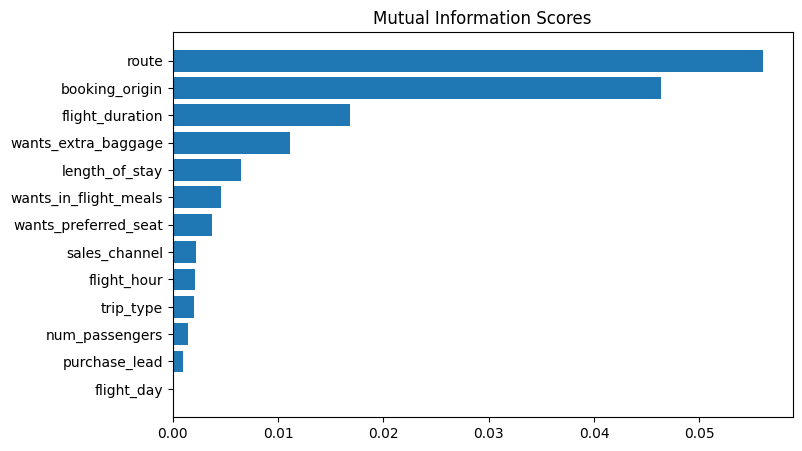

In [57]:
def plot_mi_scores(scores):
  scores=scores.sort_values(ascending=True)
  width=np.arange(len(scores))
  ticks=list(scores.index)
  plt.barh(width,scores)
  plt.yticks(width,ticks)
  plt.title("Mutual Information Scores")

plt.figure(dpi=100,figsize=(8,5))
plot_mi_scores(mi_scores)

In [58]:
from sklearn.model_selection import train_test_split

def dataset(X,y):
 train_full_X,val_X,train_full_y,val_y=train_test_split(X,y,test_size=0.2,random_state=0) #This line splits the dataset into a full training set (train_full_X, train_full_y) and a validation set (val_X, val_y).

 train_X, test_X, train_y, test_y=train_test_split(train_full_X,train_full_y,test_size=0.2,random_state=0)#This line further splits the full training set into a smaller training set (train_X, train_y) and a testing set (test_X, test_y).

 return (train_X, val_X, train_y, val_y, test_X, test_y)
 #This line returns the training and validation sets from the function

In [59]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
  scaler=MinMaxScaler()
  scaler.fit(X)
  return X

# Model 1: Random Forest Classifier with top 6 features

In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']
X= df[features]
#one hot encoding
X=pd.get_dummies(X,columns=features) #For each identified categorical feature, the function creates a set of binary dummy variables (0s and 1s), one for each unique category in that feature.
#This means that only the specified features will be one-hot encoded, while the other features in the DataFrame will remain unchanged.
X=scale(X)
y=df.booking_complete

X_train,X_val,y_train,y_val,X_test,y_test=dataset(X,y)

forest_model=RandomForestClassifier(random_state=1)
forest_model.fit(X_train,y_train)

# Predictions on validation set
preds_val=forest_model.predict(X_val)

# Evaluation on validation set
print('VAL_ACCURACY:',accuracy_score(y_val,preds_val)*100)
print('VAL_ROC_AUC score:',roc_auc_score(y_val,preds_val))

# Predictions on test set
preds_test=forest_model.predict(X_test)

# Evaluation on test set
print('TEST_ACCURACY:',accuracy_score(y_test,preds_test)*100)
print('TEST_ROC_AUC_Score:',roc_auc_score(y_test,preds_test))

VAL_ACCURACY: 83.47
VAL_ROC_AUC score: 0.5675161132484338
TEST_ACCURACY: 83.0125
TEST_ROC_AUC_Score: 0.5616868676716431





# Model 2 : Random forest classifier with all features


In [61]:
X=df.drop('booking_complete',axis=1)
#one_hot_encoding
X=pd.get_dummies(X)#using the entire DataFrame df without specifying any particular features. When you apply pd.get_dummies(X) without specifying columns,
#it will perform one-hot encoding on all categorical columns present in the dataFrame X. This approach is useful when you want to one-hot encode all categorical features in the DataFrame without specifying each feature individually.
X=scale(X)
y=df.booking_complete

X_train,X_val,y_train,y_val,X_test,y_test=dataset(X,y)

forest_model=RandomForestClassifier(random_state=1)
forest_model.fit(X_train,y_train)

# Predictions on validation set
preds_val=forest_model.predict(X_val)

# Evaluation on validation set
print('VAL_ACCURACY:',accuracy_score(y_val,preds_val)*100)
print('TEST_AUC score:',roc_auc_score(y_val,preds_val))

# Predictions on test set
preds_test=forest_model.predict(X_test)

# Evaluation on test set
print('VAL_ACCURACY:',accuracy_score(y_test,preds_test)*100)
print('TEST_ROC_AUC_Score:',roc_auc_score(y_test,preds_test))


VAL_ACCURACY: 84.93
TEST_AUC score: 0.552220607840723
VAL_ACCURACY: 84.6
TEST_ROC_AUC_Score: 0.5477099134714314


# Model 3 : XGB classifier with top 6 features

In [62]:
from xgboost import XGBClassifier

features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']

X=df[features]

#one hot encoding
X=pd.get_dummies(X, columns=features)
X=scale(X)

y=df.booking_complete

X_train,X_val,y_train,y_val,X_test,y_test=dataset(X,y)

xgb_model=XGBClassifier()
xgb_model.fit(X_train,y_train)


# Predictions on validation set
preds_val_xgb=xgb_model.predict(X_val)

# Evaluation on validation set
print('VAK_ACCURACY:',accuracy_score(y_val,preds_val_xgb)*100)
print('VAL_AUC score:',roc_auc_score(y_val,preds_val_xgb))

# Predictions on test set
preds_test_xgb=xgb_model.predict(X_test)

# Evaluation on test set
print('TEST_ACCURACY:',accuracy_score(y_test,preds_test_xgb)*100)
print('TEST_ROC_AUC_Score:',roc_auc_score(y_test,preds_test_xgb))


VAK_ACCURACY: 84.78999999999999
VAL_AUC score: 0.5198953634698564
TEST_ACCURACY: 84.78750000000001
TEST_ROC_AUC_Score: 0.5217606895871965


# Model 4 : XGB classifier with all features

In [65]:
from xgboost import XGBClassifier


#one hot encoding
X=pd.get_dummies(X)
X=scale(X)

y=df.booking_complete

X_train,X_val,y_train,y_val,X_test,y_test=dataset(X,y)

xgb_model=XGBClassifier()
xgb_model.fit(X_train,y_train)


# Predictions on validation set
preds_val_xgb=xgb_model.predict(X_val)

# Evaluation on validation set
print('VAK_ACCURACY:',accuracy_score(y_val,preds_val_xgb)*100)
print('VAL_AUC score:',roc_auc_score(y_val,preds_val_xgb))

# Predictions on test set
preds_test_xgb=xgb_model.predict(X_test)

# Evaluation on test set
print('TEST_ACCURACY:',accuracy_score(y_test,preds_test_xgb)*100)
print('TEST_ROC_AUC_Score:',roc_auc_score(y_test,preds_test_xgb))

VAK_ACCURACY: 85.05
VAL_AUC score: 0.5458671249547634
TEST_ACCURACY: 84.5
TEST_ROC_AUC_Score: 0.535622327390776


Finalizing random forest model with all features as final model, as it has the accuracy and higher auc score compared to other models Validating with test data set

In [63]:
X=df.drop('booking_complete',axis=1)
#one_hot_encoding
X=pd.get_dummies(X)#using the entire DataFrame df without specifying any particular features. When you apply pd.get_dummies(X) without specifying columns,
#it will perform one-hot encoding on all categorical columns present in the dataFrame X. This approach is useful when you want to one-hot encode all categorical features in the DataFrame without specifying each feature individually.
X=scale(X)
y=df.booking_complete

X_train,X_val,y_train,y_val,X_test,y_test=dataset(X,y)

forest_model=RandomForestClassifier(random_state=1)
forest_model.fit(X_train,y_train)


# Predictions on test set
preds_test=forest_model.predict(X_test)

# Evaluation on test set
print('VAL_ACCURACY:',accuracy_score(y_test,preds_test)*100)
print('TEST_ROC_AUC_Score:',roc_auc_score(y_test,preds_test))

VAL_ACCURACY: 84.6
TEST_ROC_AUC_Score: 0.5477099134714314
